# 0. Functions for later usage

### 0.0 Import libraries

In [3]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from colorama import Back, Fore
import inspect
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import plot_model

### 0.1 Function 1: display_filtered_images -> this function displays different pictures from our dataset

In [4]:
def display_filtered_images(df, age=None, ethnicity=None, gender=None, num_images=8, figsize=(20, 4)):
    """
    Display images filtered by age, ethnicity, and gender.
    
    Parameters:
    - df: DataFrame containing the image data and labels.
    - age: Filter for the age of the individuals (int or None).
    - ethnicity: Filter for the ethnicity of the individuals (int or None).
    - gender: Filter for the gender of the individuals (int or None).
    - num_images: Number of images to display.
    - figsize: Size of the figure.
    """
    
    # Apply filters
    filtered_df = df
    if age is not None:
        filtered_df = filtered_df[filtered_df['age'] == age]
    if ethnicity is not None:
        filtered_df = filtered_df[filtered_df['ethnicity'] == ethnicity]
    if gender is not None:
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    
    # Ensure we don't try to display more images than available after filtering
    num_images = min(len(filtered_df), num_images)
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for i in range(num_images):
        # Directly use the pixel array if it's already in the correct format
        img_array = filtered_df.iloc[i]['pixels']
        if isinstance(img_array, np.ndarray):
            img_array = img_array.reshape(48, 48)  # Use directly if it's a numpy array
        else:
            img_array = img_array.numpy().reshape(48, 48)  # Convert to numpy array and then reshape
        ax = axes[i] if num_images > 1 else axes  # Handle case of num_images == 1
        # Display the image
        ax.imshow(img_array, cmap='gray')
        # Optionally, set a title with more information
        ax.set_title(f"Age: {filtered_df.iloc[i]['age']}\nEthnicity: {filtered_df.iloc[i]['ethnicity']}\nGender: {filtered_df.iloc[i]['gender']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


### 0.2 Function 2: display_misclassified_images_by_labels -> this function displays misclassified pictures after the training

In [5]:
def display_misclassified_images_by_labels(images, true_labels, model, age_gender_data, filter_by=None, num_images=20, num_columns=4, figsize=(16, 16)):
    """
    Display a grid of misclassified images with detailed labels, with optional filtering by labels.

    Parameters:
    - images: Numpy array of images from the validation set.
    - true_labels: True labels corresponding to the images.
    - model: Trained TensorFlow/Keras model.
    - age_gender_data: DataFrame containing the validation set with labels.
    - filter_by: Dictionary containing filters for age, ethnicity, and gender (e.g., {'age': 25}).
    - num_images: Total number of misclassified images to display.
    - num_columns: Number of image columns in the grid.
    - figsize: Size of the figure.
    """

    misclassified_info = []

    # Evaluate model and find misclassified images
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    mask = pred_labels != true_labels

    for i in range(len(images)):
        if mask[i]:
            # Assuming the images are already properly indexed in age_gender_data
            misclassified_info.append((images[i], pred_labels[i], true_labels[i], i))

    # Apply filters if provided
    if filter_by:
        misclassified_info = [info for info in misclassified_info if all(
            age_gender_data.iloc[info[3]][key] == value for key, value in filter_by.items())]

    # Limit the number of images to display
    misclassified_info = misclassified_info[:num_images]

    # Display images in a grid
    num_rows = int(np.ceil(len(misclassified_info) / num_columns))
    plt.figure(figsize=figsize)

    for idx, (img, pred, true, original_idx) in enumerate(misclassified_info):
        plt.subplot(num_rows, num_columns, idx+1)
        img = img.reshape(48, 48)  # Adjust shape as needed
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(
            f"Age: {age_gender_data.iloc[original_idx]['age']}, "
            f"Ethnicity: {age_gender_data.iloc[original_idx]['ethnicity']}, "
            f"Gender: {age_gender_data.iloc[original_idx]['gender']}\n"
            f"True: {true}, Pred: {pred}"
        )
    plt.tight_layout()
    plt.show()


### 0.3 Function 3: calculate_combined_misclassification_info -> this function displays the absolute and relative volumes of missclassified instances/pictures broken down by age, gender and ethnicity.

In [6]:
def calculate_combined_misclassification_info(y_true, y_pred, data, category_names, age_bucket_size=5):
    """
    Calculate and print the misclassification rates and distribution for each label in each category,
    with ages bucketed into specified tranches.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - data: DataFrame containing the category labels
    - category_names: list of column names in the DataFrame that are categories
    - age_bucket_size: size of the age buckets (default is 5 years)
    """
    # Initialize dictionaries to count total and misclassified instances per label
    total_counts = {name: defaultdict(int) for name in category_names}
    misclassified_counts = {name: defaultdict(int) for name in category_names}

    # Function to bucket the age
    def bucket_age(age):
        return f"{age // age_bucket_size * age_bucket_size}-{(age // age_bucket_size + 1) * age_bucket_size - 1}"

    # Iterate over the dataset and populate the counts
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        for name in category_names:
            category_value = data.iloc[i][name]
            if name == 'age':
                category_value = bucket_age(category_value)
                
            total_counts[name][category_value] += 1
            if true != pred:
                misclassified_counts[name][category_value] += 1

    # Now calculate and print the misclassification rates and distribution
    for name in category_names:
        print(f"\n{name} - Misclassification rates:")
        for category_value, count in sorted(total_counts[name].items()):
            misclassified = misclassified_counts[name][category_value]
            total = count
            percentage = (misclassified / total) * 100 if total > 0 else 0
            print(f"  {category_value}: Total = {total}, Misclassified = {misclassified} ({percentage:.2f}%)")

        print(f"\n{name} - Misclassification distribution:")
        total_misclassified = sum(misclassified_counts[name].values())
        for category_value, misclassified in sorted(misclassified_counts[name].items()):
            distribution_percentage = (misclassified / total_misclassified) * 100 if total_misclassified > 0 else 0
            print(f"  {category_value}: Misclassified = {misclassified} ({distribution_percentage:.2f}%) of Total Misclassified = {total_misclassified}")


## Identifying the device (either CPU or GPU) used with Keras & Tensorflow

https://www.tensorflow.org/api_docs/python/tf/config/list_physical_devices

This line of code is used to list all the physical GPU devices that are available for TensorFlow to use:

```python
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
```

https://www.tensorflow.org/api_docs/python/tf/config/experimental

```python
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
```

In [7]:
# Check if TensorFlow can access the GPU
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Is a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

This line of code is enabling memory growth for the first GPU device available for TensorFlow to use.

Memory growth allows TensorFlow to allocate GPU memory based on runtime needs, rather than allocating all available GPU memory upfront. 

```python
tf.config.experimental.set_memory_growth(gpus[0], True)
```


In [8]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Prevent TensorFlow from initializing all of the GPU memory at once
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Catch the runtime error if memory growth is set after GPU initialization
        print(e)
    
    device_name = tf.test.gpu_device_name()
    if device_name:
        print(f"OK: Using GPU: {device_name}")
    else:
        print("OK: GPU found, but no device name identified.")
else:
    print("KO: Using CPU")

OK: Using GPU: /device:GPU:0


## 1. We detect the file encoding
    ## age_gender.csv
    
        # The detected encoding of the file is: ascii

In [9]:
import inspect
import chardet
def detect_file_encoding(file_path):
    """Detect the encoding of a given file."""
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read())
    return result['encoding']

# Example usage:
file_path = 'C:\\Users\\fercv\\OneDrive\\Desktop\\\AI_Master_Degree\\5_Deep_Learning\\data\\age_gender.csv'
detected_encoding = detect_file_encoding(file_path)

print(f'{Back.RED}The detected encoding of the file is:{Back.RESET}',
    f"\n{Back.BLUE}{detected_encoding}{Back.RESET}")

The detected encoding of the file is: 
ascii


## 2. We load our built-in functions for EDA

In [10]:
import inspect
import sys
sys.path.append('C:\\Users\\fercv\\OneDrive\\Desktop\\Python\\00_Basics')
from Glimpse_20231230_v1 import DataFrameGlimpser
all_members = inspect.getmembers(DataFrameGlimpser)
function_members = [member for member in all_members if inspect.isfunction(member[1])]
for name, func in function_members:
    print(name)

print(f'{Back.RED}DataFrameGlimpser type:{Back.RESET}',
    f"\n{Back.BLUE}{type(DataFrameGlimpser)}{Back.RESET}")

__init__
calculate_additional_statistics
calculate_correlation_matrix
calculate_memory_savings
color_cells
display_comprehensive_statistics
display_correlation_matrix
display_custom_correlation_matrix
display_head_and_tail
display_html
display_index_information
display_info
display_missing_values
display_shape
display_summary_statistics
display_unique_values
generate_outlier_removal_snippet
glimpse
highlight_mad
highlight_outliers
highlight_variance
identify_potential_primary_keys
plot_missing_values_bar_chart
remove_outliers
set_df_name
suggest_and_display_data_type_changes
suggest_columns_to_drop
summarize_and_display_correlations
DataFrameGlimpser type: 
<class 'type'>


In [11]:
from Visualise_Data_20240217_v3 import DataVisualizer

all_members = inspect.getmembers(DataVisualizer)
function_members = [member for member in all_members if inspect.isfunction(member[1])]
for name, func in function_members:
    print(name)
    
print(f'{Back.RED}DataVisualizer type:{Back.RESET}',
    f"\n{Back.BLUE}{type(DataVisualizer)}{Back.RESET}")

__init__
reorder_categories
set_custom_palette
visualize_all
visualize_box_violin_plots
visualize_correlation_matrix
visualize_joint_plots
visualize_kdeplots
visualize_lm_line_plots
visualize_pairplots
visualize_strip_plots
DataVisualizer type: 
<class 'type'>


## 3. We load the dataset and perfom the EDA

In [12]:
#We load the data
age_gender_data = pd.read_csv(file_path, delimiter=',', encoding=detected_encoding)

In [13]:
print(f'{Back.RED}age_gender_data type:{Back.RESET}',
    f"\n{Back.BLUE}{type(age_gender_data)}{Back.RESET}")

age_gender_data type: 
<class 'pandas.core.frame.DataFrame'>


### 3.1 We understand the dataset structure, missing values and unique values for each variable

In [14]:
glimpser = DataFrameGlimpser(age_gender_data)
#glimpser.set_df_name('age_gender_data')  # Optional: Set a custom name
#glimpser.glimpse()
glimpser.display_head_and_tail()
glimpser.display_missing_values()
glimpser.display_unique_values()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


,age,ethnicity,gender,img_name,pixels
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...
23704,99,0,1,20170110182052119.jpg.chip.jpg,156 161 160 165 170 173 166 177 183 191 187 18...


Series([], dtype: int64)

age            104
ethnicity        5
gender           2
img_name     23479
pixels       23315
dtype: int64

In [15]:
print(age_gender_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


### 3.2. We understand the images pixels size

In [16]:
# Assuming age_gender_data['pixels'][0] is a string of pixel intensities
num_pixels = len(age_gender_data['pixels'][0].split())
image_size = int(num_pixels ** 0.5)  # Assuming the images are square

print(f'{Back.RED}Each image is:{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}x{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}pixels{Back.RESET}',)

print(f'{Back.RED}The number of pixels per image is:{Back.RESET}',
    f"{Back.BLUE}{num_pixels}{Back.RESET}")

print(f'{Back.RED}num_pixels type:{Back.RESET}',
    f"\n{Back.BLUE}{type(num_pixels)}{Back.RESET}")

Each image is: 48 x 48 pixels
The number of pixels per image is: 2304
num_pixels type: 
<class 'int'>


### 3.3. We visualise the variables of our dataset

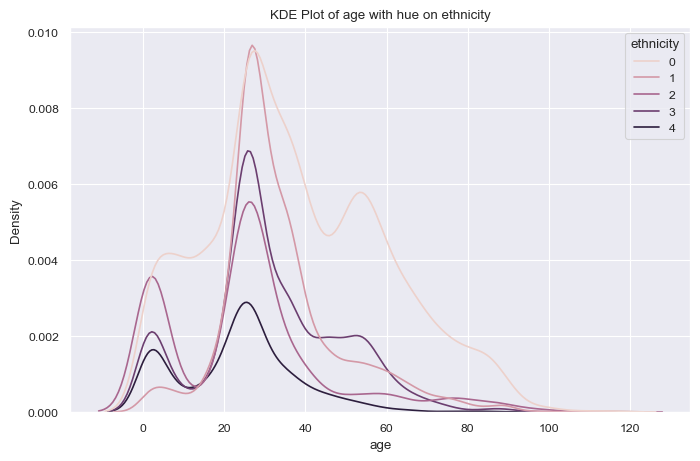

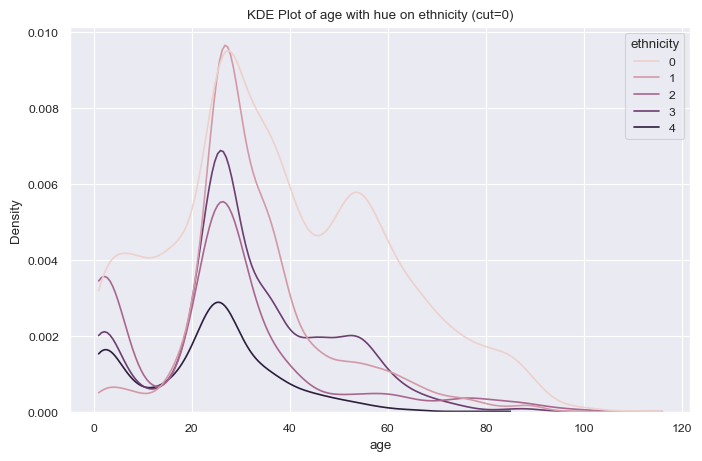

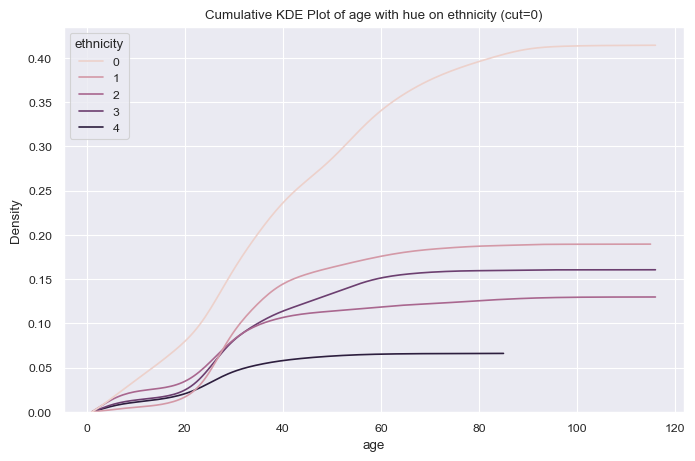

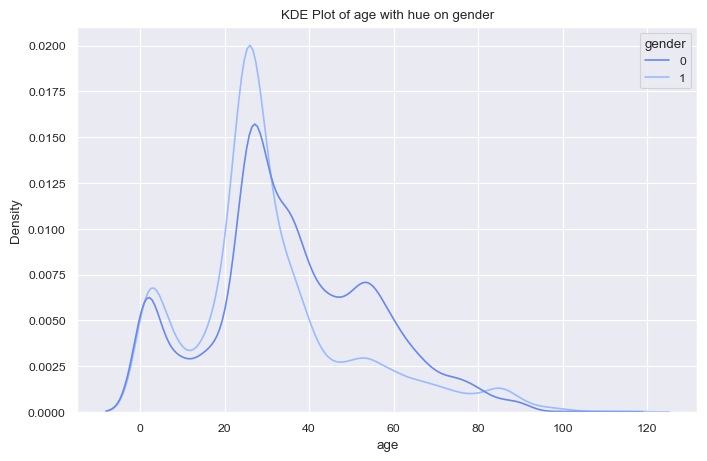

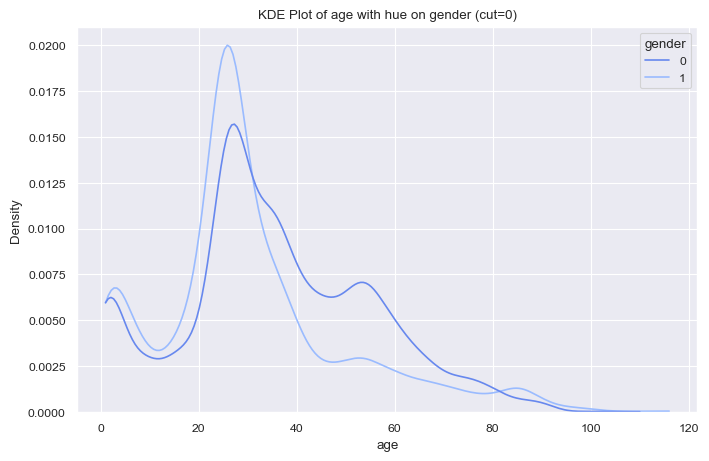

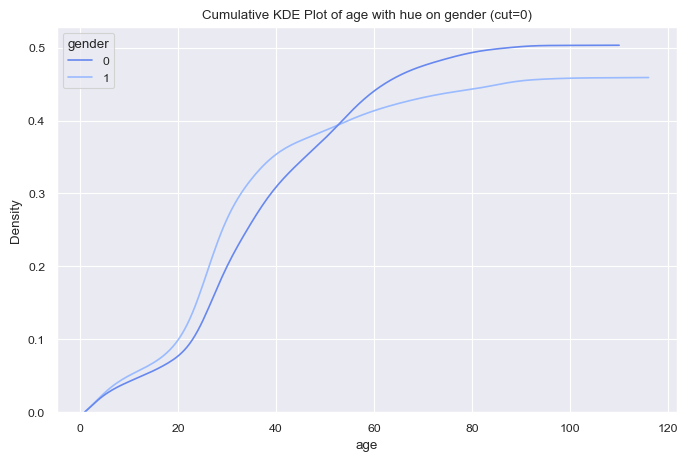

In [17]:
visualizer = DataVisualizer(age_gender_data, plot_width=8, plot_height=5)
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['ethnicity','gender'], hue=['ethnicity','gender'])
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['gender'], hue=['ethnicity','gender'])
visualizer.visualize_kdeplots(num_vars=['age'], hue=['ethnicity','gender'])

## 4- We print some pictures from our dataset to understand its content.

#### 4.0. We first apply the necessary transformations to convert the 'pixels' variable (with object type) to an array and later to a tensor

```python
return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))
```

This line of code is taking a string of pixel values, splitting it into a list, converting that list into a numpy array of type float32, and then reshaping that array into a 3D tensor with a shape of (48, 48,1)

In [19]:
# Define a function to convert pixel strings to tensors
def convert_pixels_to_tensor(pixels):
    return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))

# Copy the DataFrame and apply the conversion function
age_gender_data_tensor = age_gender_data.copy()
age_gender_data_tensor['pixels'] = age_gender_data['pixels'].apply(convert_pixels_to_tensor)

In [ ]:
# Print the type of the entire 'pixels' column
print(f'{Back.RED}age_gender_data_tensor["pixels"] type:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'])}{Back.RESET}")

# Print the type of the first item in the 'pixels' column
print(f'{Back.RED}Type of the first item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'].iloc[0])}{Back.RESET}")


age_gender_data_tensor["pixels"] type: 
<class 'pandas.core.series.Series'>
Type of the first item in age_gender_data_tensor["pixels"]: 
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
print(f'{Back.RED}First item in age_gender_data["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{age_gender_data['pixels'].iloc[0]}{Back.RESET}")
print(f'{Back.RED}First item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{age_gender_data_tensor['pixels'].iloc[0]}{Back.RESET}")

First item in age_gender_data["pixels"]: 
129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 142 145 147 144 141 143 138 131 133 134 137 139 143 147 148 149 149 149 151 151 149 147 147 146 141 139 135 137 137 137 137 138 137 134 132 129 130 124 124 115 95 52 138 139 139 135 134 138 140 140 140 140 140 140 139 134 131 127 131 131 133 138 143 148 149 149 150 151 148 144 141 138 139 133 133 137 139 139 141 140 140 136 132 131 132 125 125 115 91 50 141 145 

#### 4.1. display_filtered_images(age_gender_data, age=1, ethnicity=0, gender=0, num_images=8)

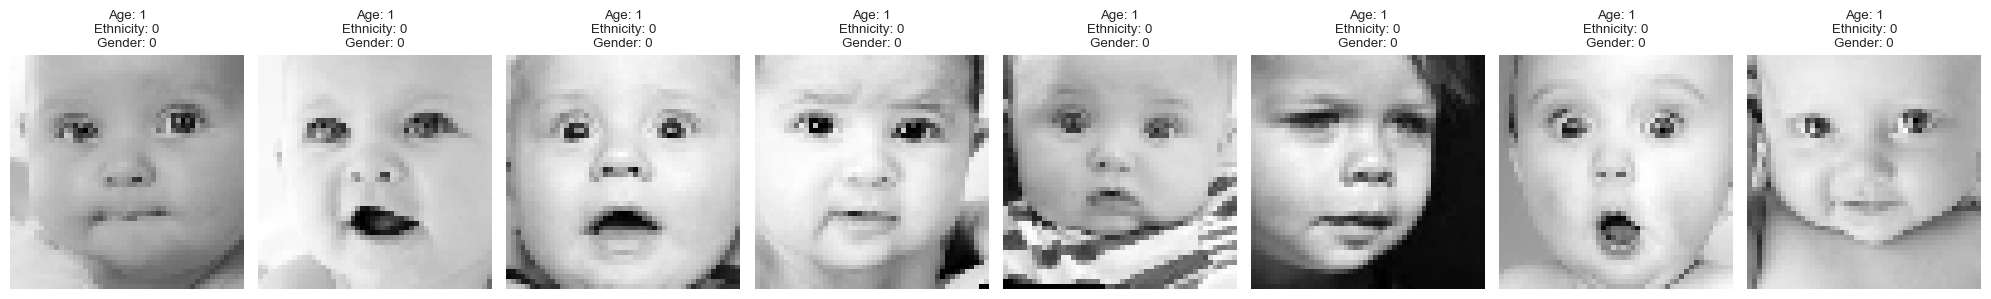

In [ ]:
# Example usage:
display_filtered_images(age_gender_data_tensor, age=1, ethnicity=0, gender=0, num_images=8)


#### 4.2. display_filtered_images(age_gender_data, age=10, ethnicity=1, gender=1, num_images=8)

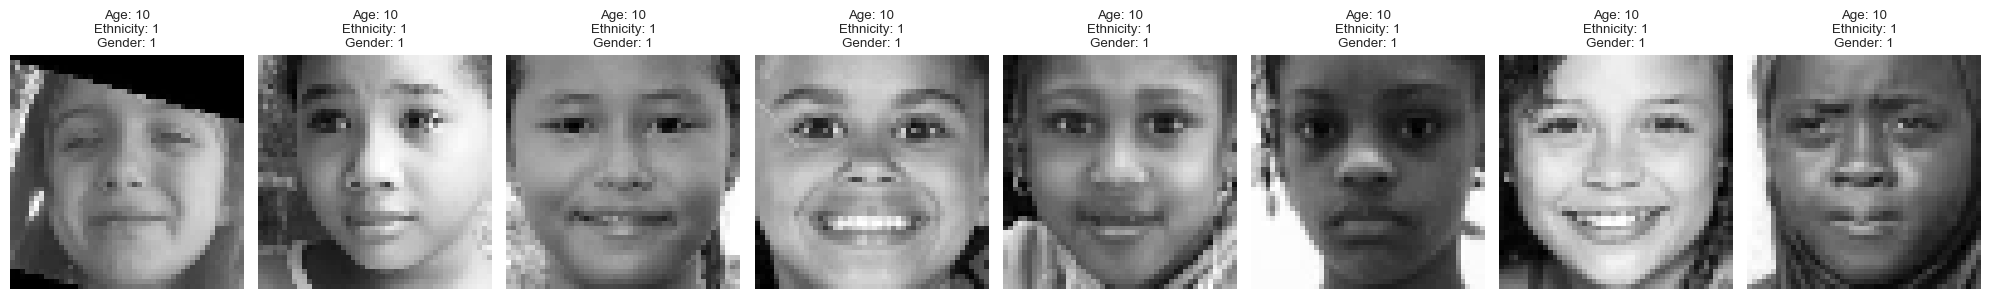

In [ ]:
display_filtered_images(age_gender_data_tensor, age=10, ethnicity=1, gender=1, num_images=8)

#### 4.3. display_filtered_images(age_gender_data, age=20, ethnicity=2, gender=0, num_images=8)

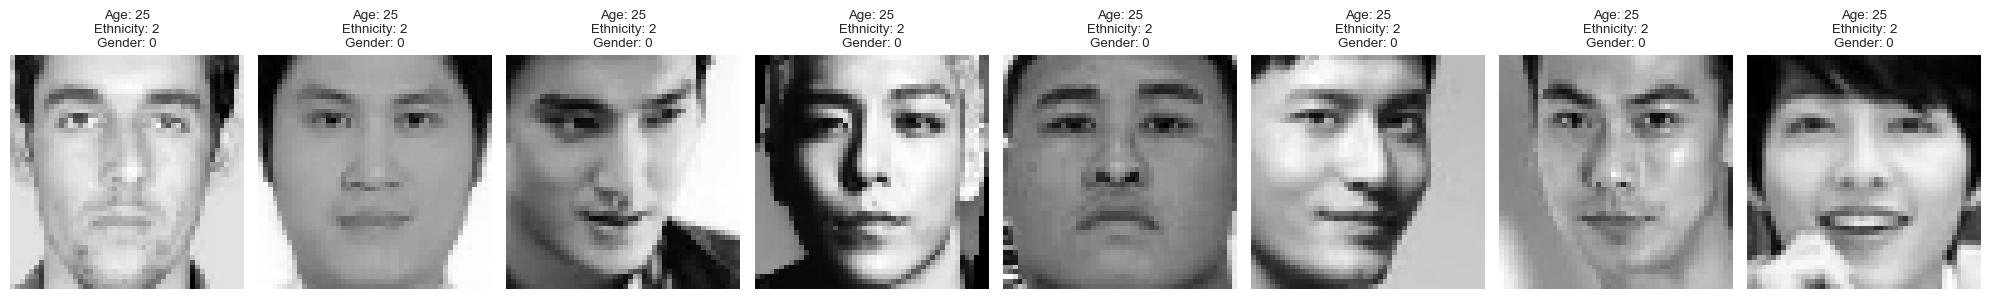

In [ ]:
display_filtered_images(age_gender_data_tensor, age=25, ethnicity=2, gender=0, num_images=8)

#### 4.4. display_filtered_images(age_gender_data, age=35, ethnicity=3, gender=1, num_images=8)

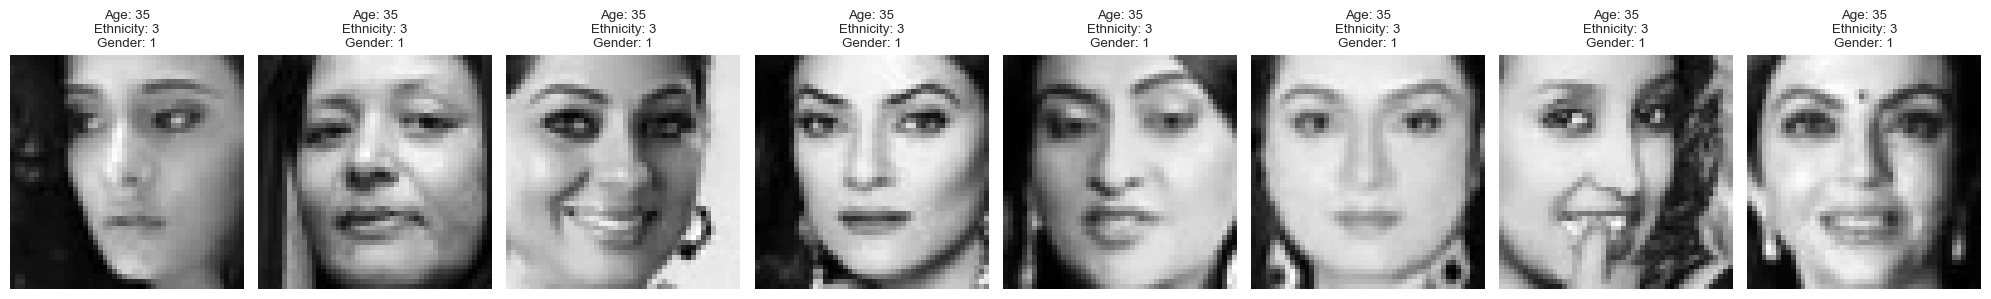

In [ ]:
display_filtered_images(age_gender_data_tensor, age=35, ethnicity=3, gender=1, num_images=8)

#### 4.5. display_filtered_images(age_gender_data, age=45, ethnicity=4, gender=0, num_images=8)

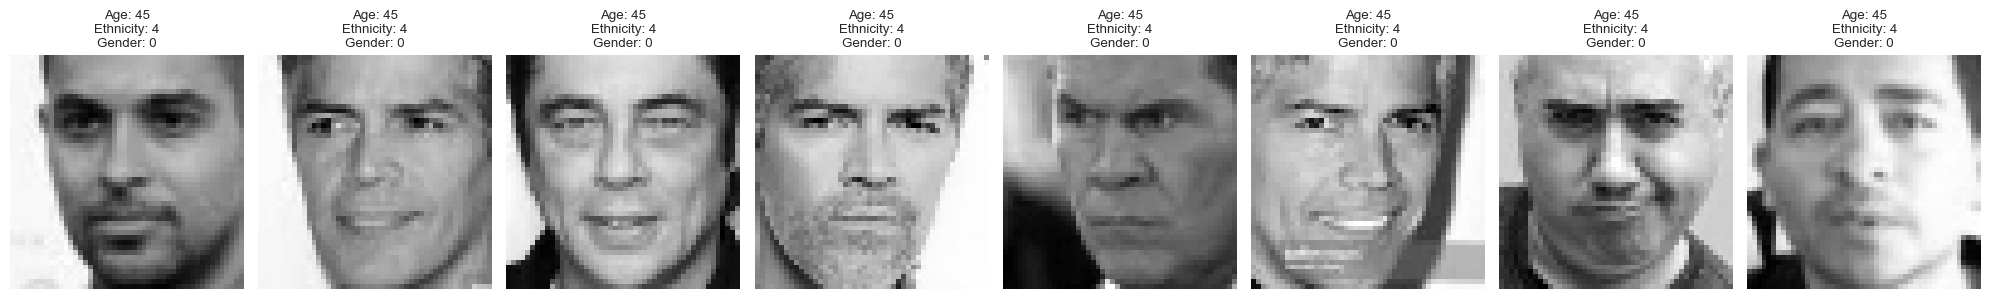

In [ ]:
display_filtered_images(age_gender_data_tensor, age=45, ethnicity=4, gender=0, num_images=8)

#### 4.6. display_filtered_images(age_gender_data, age=55, ethnicity=0, gender=1, num_images=8)

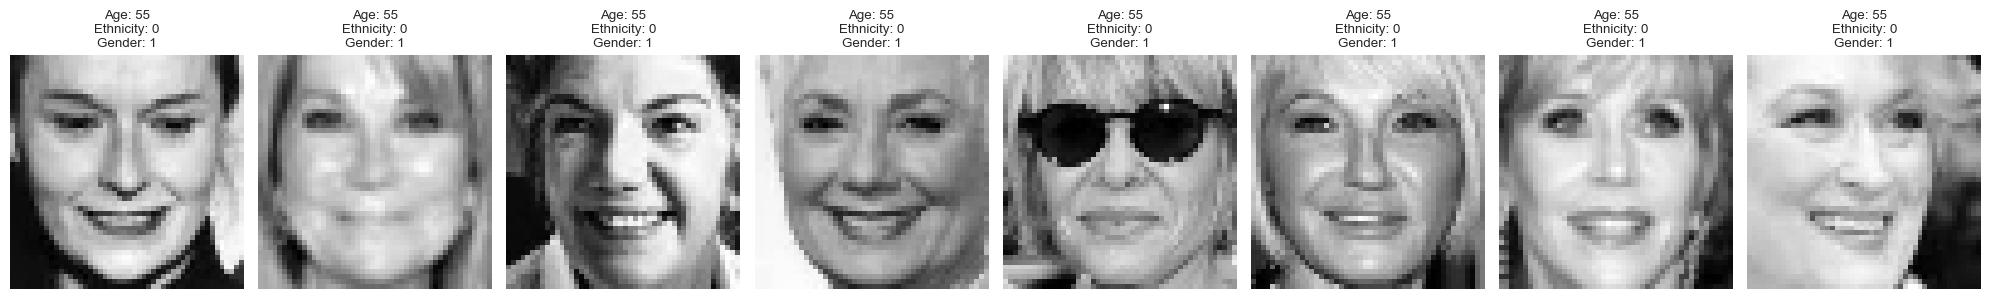

In [ ]:
display_filtered_images(age_gender_data_tensor, age=55, ethnicity=0, gender=1, num_images=8)

#### 4.7. display_filtered_images(age_gender_data, age=65, ethnicity=1, gender=0, num_images=8)

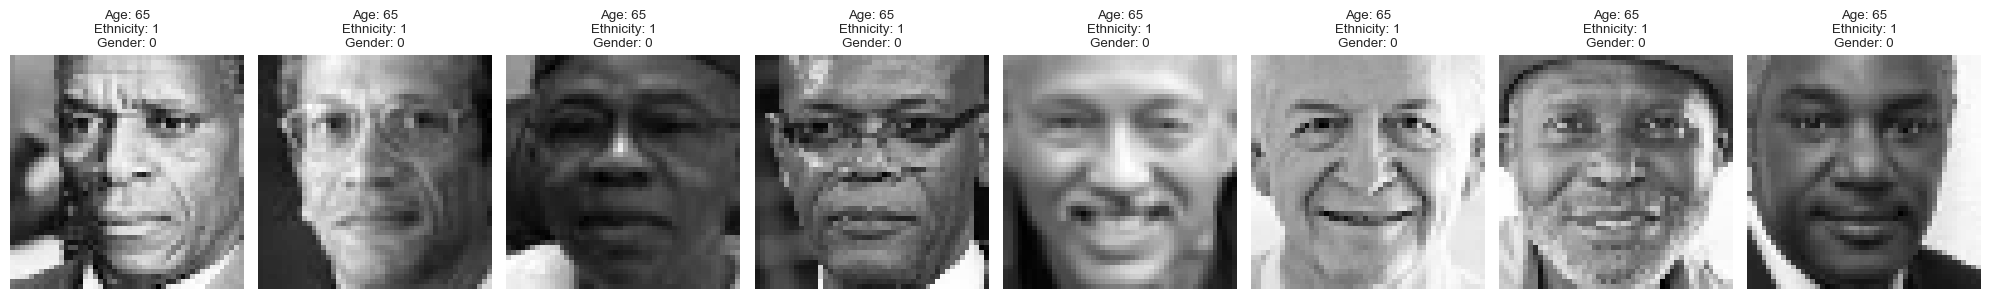

In [ ]:
display_filtered_images(age_gender_data_tensor, age=65, ethnicity=1, gender=0, num_images=8)

#### 4.8. display_filtered_images(age_gender_data, age=40, ethnicity=2, gender=1, num_images=8)

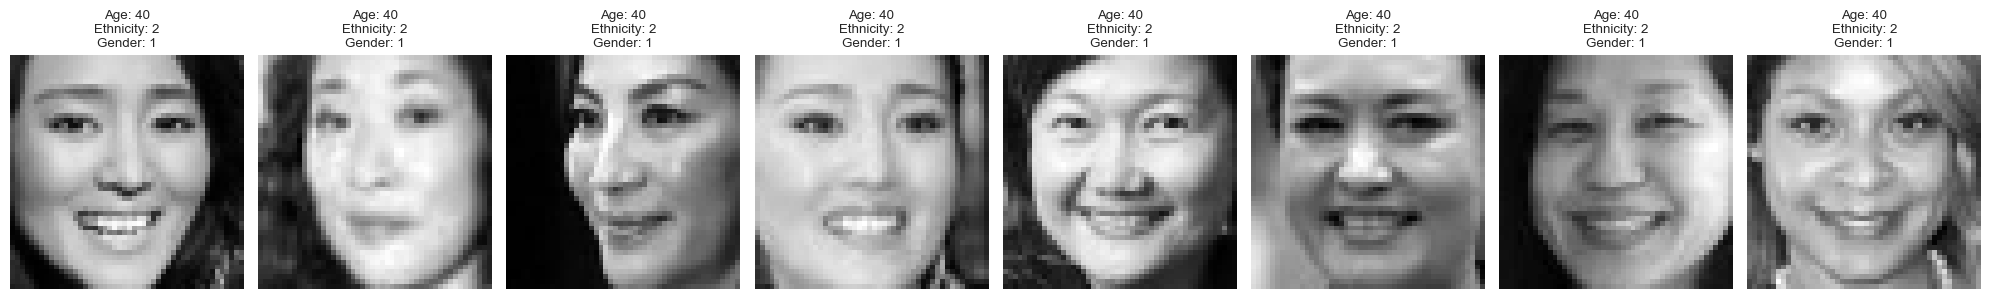

In [ ]:
display_filtered_images(age_gender_data_tensor, age=40, ethnicity=2, gender=1, num_images=8)

#### 4.9. display_filtered_images(age_gender_data, age=5, ethnicity=4, gender=1, num_images=8)

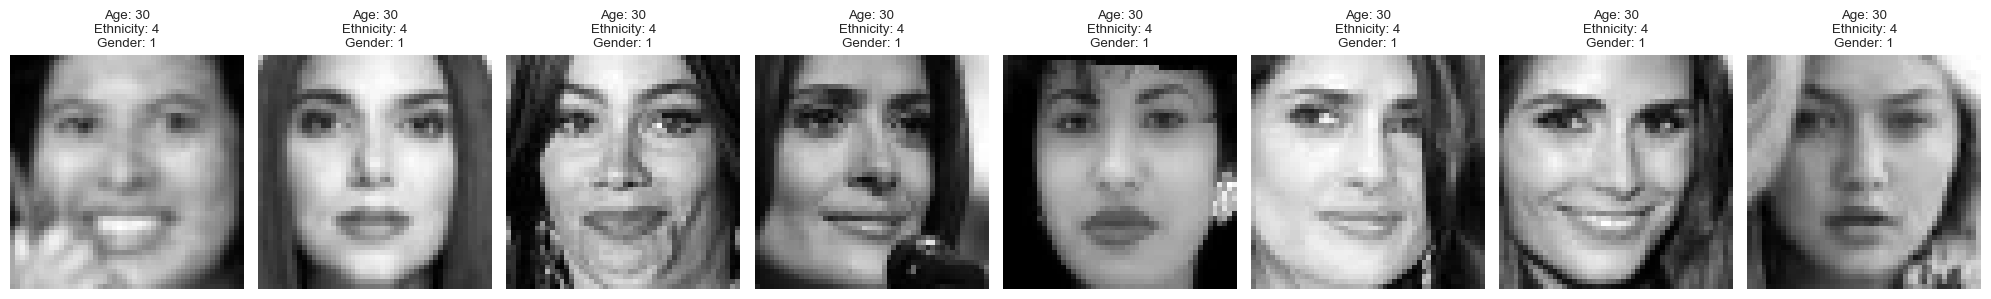

In [ ]:
display_filtered_images(age_gender_data_tensor, age=30, ethnicity=4, gender=1, num_images=8)

## 5. Preparing the data for later usage in a neural network

We have a class to carry out the data preprocessing for our neural network. It has the following built-in functions:

1. split_data

- 1.1. The function returns the training and validation indices. These indices can then be used to create training and validation datasets from the original DataFrame. The advantage of this approach is that it allows for stratified sampling, ensuring that the training and validation sets have the same class distribution as the original dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

2. preprocess

- 2.1. The `np.fromstring` function is used to convert a string of pixel values into a numpy array. The `pixel_string.decode('utf-8')` part of the code is decoding a byte string of pixel values into a regular string. The `sep=' '` argument specifies that the pixel values in the string are separated by spaces. The `dtype=np.float32` argument specifies that the data type of the numpy array should be float32.

https://numpy.org/doc/stable/reference/generated/numpy.fromstring.html
https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.float16
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape

3. create_dataset

- 3.1. `tf.data.Dataset.from_tensor_slices` function is a convenient way to create a Dataset from data in memory. It creates a dataset where each element is a slice of the input tensors.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset
https://www.tensorflow.org/api_docs/python/tf/numpy_function

- 3.2. `map` function is used to apply a function to each element in the dataset

https://docs.python.org/3/library/functions.html#map

- 3.3. `tf.numpy_function` is a TensorFlow operation that wraps a Python function. the Python function being wrapped is `self.preprocess`, and it's being passed two input tensors: `x` and `y`. `x` and `y` are the pixel data and label for an image, respectively. The dtype of the output tensors are specified as ``tf.float32` and `tf.int64`, which means the preprocess function is expected to return a tuple containing a float32 tensor and an int64 tensor.

- 3.4. The `num_parallel_calls` argument in the map function is set to `tf.data.experimental.AUTOTUNE`, which means that TensorFlow will choose the number of parallel calls to use based on available CPU.

https://www.tensorflow.org/api_docs/python/tf/data/experimental



In [21]:
class DatasetCreator:
    def __init__(self, dataframe, label_column, test_size=0.3, batch_size=32, shuffle=True, random_state=42):
        """
        Initialize the DatasetCreator with the dataframe and configuration.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the data.
            label_column (str): Column name for the label data.
            test_size (float): The proportion of the dataset to include in the test split.
            batch_size (int): Size of each batch.
            shuffle (bool): Whether to shuffle the data.
            random_state (int): The seed used by the random number generator.
        """
        self.dataframe = dataframe
        self.label_column = label_column
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state

        # Split the data
        self.train_indices, self.val_indices = self.split_data(test_size)

    def split_data(self, test_size):
        """
        Split the data into training and validation indices.

        Args:
            test_size (float): The proportion of the dataset to include in the test split.

        Returns:
            Tuple of arrays: (train_indices, val_indices)
        """
        indices = np.arange(len(self.dataframe))
        train_indices, val_indices, _, _ = train_test_split(
            indices, self.dataframe[self.label_column].values, test_size=test_size, random_state=self.random_state)
        return train_indices, val_indices

    def preprocess(self, pixel_string, label):
        """
        Preprocess the data: convert pixel string to a numpy array of type float32, 
        and then reshaping that array into a 3D tensor with a shape of (48, 48, 1)

        Args:
            pixel_string (str): The string of pixel values.
            label (int): The label associated with the pixels.

        Returns:
            Tuple of np.array for pixels and the label.
        """
        pixels = np.fromstring(pixel_string.decode('utf-8'), sep=' ', dtype=np.float32).reshape(48, 48, 1)
        return pixels, label

    def create_dataset(self, indices, shuffle):
        """
        Create and preprocess the TensorFlow dataset.

        Args:
            indices (np.array): Indices for creating the subset.

        Returns:
            tf.data.Dataset: The preprocessed dataset.
        """
        subset_dataframe = self.dataframe.iloc[indices]
        pixel_strings = subset_dataframe['pixels'].values
        labels = subset_dataframe[self.label_column].values

        dataset = tf.data.Dataset.from_tensor_slices((pixel_strings, labels))
        dataset = dataset.map(lambda x, y: tf.numpy_function(self.preprocess, [x, y], [tf.float32, tf.int64]), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(subset_dataframe))
        return dataset.batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)


#### 5.1. We instantiate the class and create the train and test datasets. We shuffle the training dataset but we don´t the testing dataset. We select the 'gender' as the target/label for the model.

In [39]:
dataset_creator = DatasetCreator(age_gender_data, 'gender')
train_dataset_2 = dataset_creator.create_dataset(dataset_creator.train_indices, shuffle=True)
val_dataset_2 = dataset_creator.create_dataset(dataset_creator.val_indices, shuffle=False)

#### 5.2. We inspect our training and validation datasets to understand their structure and element shapes of a Tensorflow `Dataset` object.

In [38]:
# Example function to inspect dataset structure and element shapes
def inspect_dataset(dataset):
    # Take one batch from the dataset
    for inputs, labels in dataset.take(1):
        # Print the shape of the inputs and labels
        print(f'{Back.RED}Input shape:{Back.RESET}', f"{Back.BLUE}{inputs.shape}{Back.RESET}")
        print(f'{Back.RED}Label shape:{Back.RESET}', f"{Back.BLUE}{labels.shape}{Back.RESET}")
        # Optionally, check the dtype
        print(f'{Back.RED}Input dtype:{Back.RESET}', f"{Back.BLUE}{inputs.dtype}{Back.RESET}")
        print(f'{Back.RED}Label dtype:{Back.RESET}', f"{Back.BLUE}{labels.dtype}{Back.RESET}")

# Assuming train_dataset and val_dataset are your datasets
print(f'{Back.RED}Training Dataset:{Back.RESET}')
inspect_dataset(train_dataset_2)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(train_dataset_2)}{Back.RESET}")
print(f'{Back.RED}Validation Dataset:{Back.RESET}')
inspect_dataset(val_dataset_2)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(val_dataset_2)}{Back.RESET}")

Training Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Validation Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [ ]:
# Generate indices for splitting
indices = np.arange(len(age_gender_data))

print(f'{Back.RED}indices type:{Back.RESET}',
    f"\n{Back.BLUE}{type(indices)}{Back.RESET}")



# Split indices
train_indices, val_indices, _, _ = train_test_split(
    indices, age_gender_data['gender'].values, test_size=0.3, random_state=42)


indices type: 
<class 'numpy.ndarray'>
indices [0]: 
[    0     1     2 ... 23702 23703 23704]


In [ ]:
import numpy as np
import tensorflow as tf

def create_dataset(dataframe, mean, std, batch_size=32, shuffle=True):
    """
    Create a TensorFlow dataset from a pandas dataframe, normalizing the data.
    """
    def preprocess(pixel_string, label):
        # Convert pixel string to an array and reshape
        pixels = np.fromstring(pixel_string.decode('utf-8'), sep=' ', dtype=np.float32).reshape(48, 48, 1)
        #pixels = (pixels - mean) / std  # Normalize
        return pixels, label

    pixel_strings = dataframe['pixels'].values
    labels = dataframe['gender'].values

    # Create and preprocess the dataset
    dataset = tf.data.Dataset.from_tensor_slices((pixel_strings, labels))
    dataset = dataset.map(lambda x, y: tf.numpy_function(preprocess, [x, y], [tf.float32, tf.int64]), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

def create_subset_dataset(dataframe, indices, mean, std, batch_size=32, shuffle=True):
    """
    Create a subset TensorFlow dataset.
    """
    subset_dataframe = dataframe.iloc[indices]
    return create_dataset(subset_dataframe, mean, std, batch_size, shuffle)

# Usage
train_dataset = create_subset_dataset(age_gender_data, train_indices, mean.numpy(), std.numpy())
val_dataset = create_subset_dataset(age_gender_data, val_indices, mean.numpy(), std.numpy(), shuffle=False)


In [ ]:
def create_dataset(dataframe, mean, std, batch_size=32, shuffle=True):
    """
    Create a TensorFlow dataset from a pandas dataframe, using calculated mean and std for normalization.

    Args:
        dataframe (pd.DataFrame): DataFrame containing the data.
        mean (float): The mean of the pixel values.
        std (float): The standard deviation of the pixel values.
        batch_size (int): Size of each batch.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        dataset (tf.data.Dataset): A TensorFlow dataset.
    """
    def preprocess(pixel_string, label):
        # Function to preprocess your data
        def _preprocess(pixel_string, label):
            pixels = np.fromstring(pixel_string.decode('utf-8'), sep=' ', dtype=np.float32)
            pixels = pixels.reshape(48, 48, 1)  # Explicitly set shape
            # Normalize using calculated mean and std
            pixels = (pixels - mean) / std
            return pixels, label
        
        # Wrap the numpy-based preprocessing with tf.numpy_function
        pixels, label = tf.numpy_function(_preprocess, [pixel_string, label], [tf.float32, tf.int64])
        
        # Explicitly set the shapes of the tensors
        pixels.set_shape((48, 48, 1))
        label.set_shape(())
        
        return pixels, label

    # Extract features and labels
    pixel_strings = dataframe['pixels'].values
    labels = dataframe['gender'].values

    # Create a tf.data.Dataset from the features and labels
    dataset = tf.data.Dataset.from_tensor_slices((pixel_strings, labels))

    # Map the preprocessing function
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
def create_subset_dataset(dataframe, indices, mean, std, batch_size=32, shuffle=True):
    """
    Create a subset TensorFlow dataset for either training or validation.

    Args:
        dataframe (pd.DataFrame): The full DataFrame.
        indices (np.array): Indices for the subset.
        mean (float): Mean for normalization.
        std (float): Standard deviation for normalization.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the subset.

    Returns:
        A tf.data.Dataset object for the specified subset.
    """
    subset_dataframe = dataframe.iloc[indices]
    return create_dataset(subset_dataframe, mean, std, batch_size=batch_size, shuffle=shuffle)


In [ ]:
# Assuming 'mean' and 'std' have been calculated as before
train_dataset = create_subset_dataset(age_gender_data, train_indices, mean.numpy(), std.numpy(), batch_size=32, shuffle=True)
val_dataset = create_subset_dataset(age_gender_data, val_indices, mean.numpy(), std.numpy(), batch_size=32, shuffle=False)

In [ ]:
print(f'{Back.RED}dataset type:{Back.RESET}',
    f"\n{Back.BLUE}{type(train_dataset)}{Back.RESET}")

print(f'{Back.RED}dataset type:{Back.RESET}',
    f"\n{Back.BLUE}{type(val_dataset)}{Back.RESET}")

dataset type: 
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
dataset type: 
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [ ]:
# Example function to inspect dataset structure and element shapes
def inspect_dataset(dataset):
    # Take one batch from the dataset
    for inputs, labels in dataset.take(1):
        # Print the shape of the inputs and labels
        print("Input shape:", inputs.shape)
        print("Label shape:", labels.shape)
        # Optionally, check the dtype
        print("Input dtype:", inputs.dtype)
        print("Label dtype:", labels.dtype)

# Assuming train_dataset and val_dataset are your datasets
print("Training Dataset:")
inspect_dataset(train_dataset)

print("\nValidation Dataset:")
inspect_dataset(val_dataset)


Training Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>

Validation Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>


In [ ]:
print(train_dataset.element_spec)
print(val_dataset.element_spec)


(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [ ]:
model = models.Sequential([
    # Flatten the input layer
    layers.Flatten(input_shape=(48, 48, 1)),  # Assuming grayscale images
    # First fully connected layer
    layers.Dense(512, activation='relu'),
    # Batch normalization layer to normalize the activations of the previous layer at each batch
    layers.BatchNormalization(),
    # Dropout layer to help prevent overfitting
    layers.Dropout(0.5),
    # Second fully connected layer
    layers.Dense(128, activation='relu'),
    # Batch normalization layer to normalize the activations of the previous layer at each batch
    layers.BatchNormalization(),
    # Dropout layer to help prevent overfitting
    layers.Dropout(0.5),
    # Output layer with 2 units for 2 classes, using softmax for multi-class classification
    layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 512)               1180160   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [ ]:
# Visualize the model
plot_model(model, to_file='GenderClassificationModel_keras.png', show_shapes=True, show_layer_names=True, rankdir='TB')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
model.save('GenderClassModelSavedModel_keras')

INFO:tensorflow:Assets written to: GenderClassModelSavedModel_keras\assets


In [ ]:
# Optimiser SGD with learning rate 0.01 and momentum 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Start timer
start_time= time.time()
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset
                    )
# End timer
end_time = time.time()

Epoch 1/3


519/519 [==============================] - 283s 172ms/step - loss: 0.6318 - accuracy: 0.7060 - val_loss: 0.9021 - val_accuracy: 0.5823
Epoch 2/3
519/519 [==============================] - 137s 62ms/step - loss: 0.5481 - accuracy: 0.7444 - val_loss: 0.8600 - val_accuracy: 0.6261
Epoch 3/3
519/519 [==============================] - 110s 65ms/step - loss: 0.5424 - accuracy: 0.7460 - val_loss: 1.3767 - val_accuracy: 0.5582


### 9.6 Training time

In [ ]:
# Calculate and print the duration
duration = end_time - start_time
print(f'{Back.RED}Training completed in (seconds):{Back.RESET}',
    f"\n{Back.BLUE}{duration:.3f}{Back.RESET}")

Training completed in (seconds): 
21.935


In [ ]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')


223/223 [==============================] - 30s 133ms/step - loss: 1.3767 - accuracy: 0.5582
Validation Loss: 1.3766975402832031, Validation Accuracy: 0.5582114458084106


## 9. We create our first neural network: with the following architecture:

- (fc1): Linear(in_features=2304, out_features=512, bias=True) -> with activation function: relu
- (fc2): Linear(in_features=512, out_features=128, bias=True) -> with activation function: relu
- (fc3): Linear(in_features=128, out_features=2, bias=True) -> with activation function: log_softmax

### 9.1 Neural network architecture

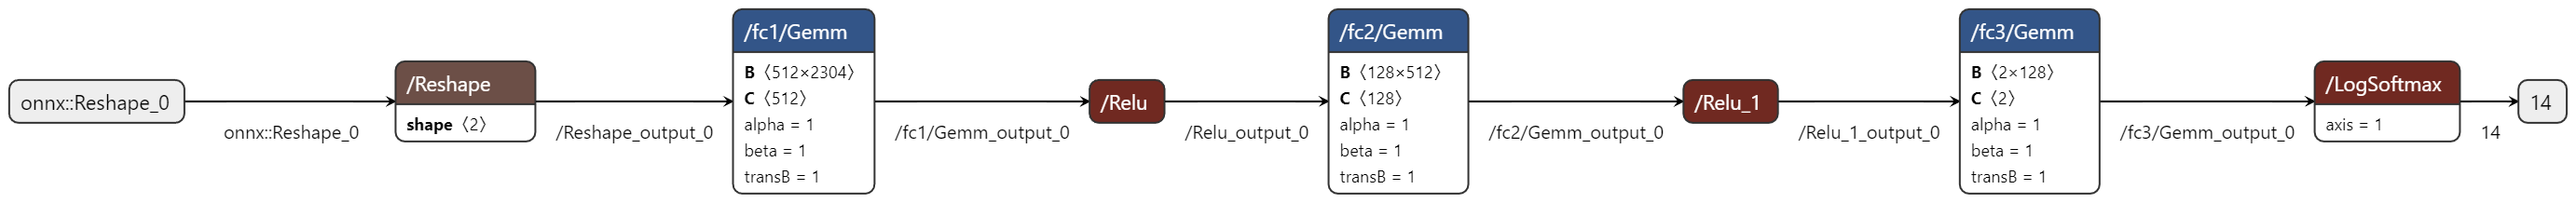

In [ ]:
from IPython.display import Image, display
image_path = "C:\\Users\\fercv\\OneDrive\\Desktop\\\AI_Master_Degree\\5_Deep_Learning\\Assignment\\GenderClassificationModel.onnx.png"
display(Image(filename=image_path))

### 9.2 Neural network model definition: GenderClassificationModel

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class GenderClassificationModel(nn.Module):
    def __init__(self):
        super(GenderClassificationModel, self).__init__()
        # Adjust the input layer to match your image size (48x48 pixels)
        self.fc1 = nn.Linear(48*48, 512) # Flatten the input in the forward method
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 2 classes for gender
    
    def forward(self, x):
        # Ensure the input x is flattened
        x = x.view(-1, 48*48)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Use log_softmax for the output layer as you have 2 classes
        return F.log_softmax(self.fc3(x), dim=1)

# Assuming `device` is defined (e.g., 'cuda' or 'cpu')
model = GenderClassificationModel().to(device)
print(model)

summary(model, input_size=(1, 48*48))


ModuleNotFoundError: No module named 'torch'

### 9.3 Neural network visual representation and storage

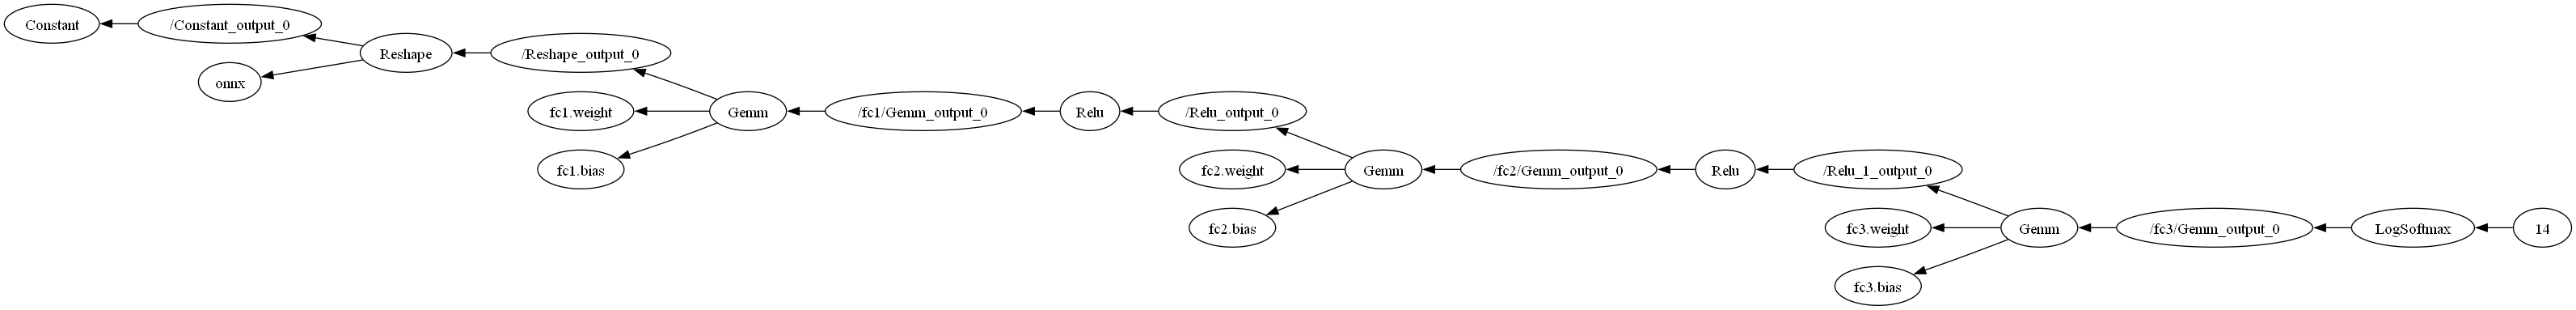

In [ ]:
import torch
import onnx
from graphviz import Digraph

# Define your PyTorch model here (make sure to replace 'YourModel' with your actual model class)
# model = YourModel()

# Ensure the model is in evaluation mode
model.eval()

# Create a dummy input tensor appropriate for your model
dummy_input = torch.randn(1, 48*48, device=device)

# Export the PyTorch model to ONNX format
torch.onnx.export(model, dummy_input, 'GenderClassificationModel.onnx', export_params=True, opset_version=11)

# Load the exported ONNX model
onnx_model = onnx.load('GenderClassificationModel.onnx')

# Create a new directed graph using Graphviz
dot = Digraph(format='png')

# Add nodes and edges to the graph
for i, node in enumerate(onnx_model.graph.node):
    dot.node(str(i), node.op_type)
    for input_name in node.input:
        dot.edge(str(i), input_name)
    for output_name in node.output:
        dot.edge(output_name, str(i))

# Customize graph properties to layout the graph from left to right
dot.attr(rankdir='RL')

# Render the ONNX model graph to a file
dot.render('GenderClassificationModel')

# Optional: Display the graph (if running in a Jupyter notebook or similar environment)
from IPython.display import Image
Image(filename='GenderClassificationModel.png')


### 9.4 Dataset train and test split keeping the indexes -> this enables later analysis to understand the subpopulations that our model is not classifying properly.

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import torch

class CustomDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing the data.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the item to fetch
        Returns:
            sample (Tensor): Transformed sample
        """
        # Assuming pixels are stored as space-separated strings in the dataframe
        pixel_string = self.dataframe.iloc[idx]['pixels']
        pixels = np.fromstring(pixel_string, sep=' ', dtype=np.float32).reshape(1, 48, 48)
        pixels = torch.tensor(pixels)

        if self.transforms:
            pixels = self.transforms(pixels)

        # Fetch the label
        label = self.dataframe.iloc[idx]['gender']
        label = torch.tensor(label, dtype=torch.long)

        return pixels, label


train_transforms = transforms.Compose([
    # Assuming no RandomCrop is necessary for 48x48 images. Adjust if images are larger.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Note: Our custom conversion already outputs a tensor, so this might be redundant or need adjustment
    # Normalize using mean and std specific to your dataset or a generic value for grayscale
    transforms.Normalize(mean=mean, std=std)  # Adjust these values based on your dataset
])

In [ ]:
# Define your transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(),  # This might be redundant if your dataset already outputs tensors
    transforms.Normalize(mean=[mean], std=[std])  # Adjust mean and std
])

# Create the dataset
dataset = CustomDataset(age_gender_data, transforms=train_transforms)

print(f'{Back.RED}dataset type:{Back.RESET}',
    f"\n{Back.BLUE}{type(dataset)}{Back.RESET}")

dataset type: 
<class '__main__.CustomDataset'>


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming dataset is an instance of CustomDataset
indices = np.arange(len(dataset))

# Split indices
train_indices, val_indices, _, _ = train_test_split(
    indices, dataset.dataframe['gender'].values, test_size=0.3, random_state=42)

# Function to fetch data based on indices
def fetch_data_from_indices(dataset, indices):
    X = []
    y = []
    for idx in indices:
        data, label = dataset[idx]
        X.append(data)
        y.append(label)
    # Stack all data and labels
    X = torch.stack(X)
    y = torch.stack(y)
    return X, y

# Fetch data for training and validation sets
X_train, y_train = fetch_data_from_indices(dataset, train_indices)
X_val, y_val = fetch_data_from_indices(dataset, val_indices)

# Create TensorDatasets
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

# Create DataLoader instances
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


### 9.5 Model training with GPU if available.

- Loss function: CrossEntropyLoss
- Optimiser: Adam

In [ ]:
#We import the library to display the timer

import time

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch
# Define your model (assuming `MyModel` is a class defining your CNN)
model = GenderClassificationModel().to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Assuming device is defined as follows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

# Start timer
start_time= time.time()
num_epochs = 15  # Or whatever number of epochs you've set

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)  # Multiply by batch size
        
        # Calculate predictions for F1-Score
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1_score = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
    
    print(f'{Back.RED}Epoch:{Back.RESET} {Back.BLUE}{epoch+1}/{num_epochs}{Back.RESET}, '
          f'{Back.RED}Loss:{Back.RESET} {Back.BLUE}{epoch_loss:.4f}{Back.RESET}, '
          f'{Back.RED}Accuracy:{Back.RESET} {Back.BLUE}{epoch_accuracy*100:.2f}%{Back.RESET}, '
          f'{Back.RED}F1-Score:{Back.RESET} {Back.BLUE}{epoch_f1_score:.4f}{Back.RESET}')
    
# End timer
end_time = time.time()

Training on device: cuda
Epoch: 1/15, Loss: 13.9620, Accuracy: 68.28%, F1-Score: 0.6828
Epoch: 2/15, Loss: 0.4958, Accuracy: 77.51%, F1-Score: 0.7750
Epoch: 3/15, Loss: 0.6151, Accuracy: 65.55%, F1-Score: 0.6340
Epoch: 4/15, Loss: 0.6591, Accuracy: 60.34%, F1-Score: 0.5443
Epoch: 5/15, Loss: 0.5676, Accuracy: 72.12%, F1-Score: 0.7169
Epoch: 6/15, Loss: 0.5963, Accuracy: 68.35%, F1-Score: 0.6712
Epoch: 7/15, Loss: 0.6928, Accuracy: 52.13%, F1-Score: 0.3573
Epoch: 8/15, Loss: 0.6925, Accuracy: 52.13%, F1-Score: 0.3573
Epoch: 9/15, Loss: 0.6923, Accuracy: 52.13%, F1-Score: 0.3573
Epoch: 10/15, Loss: 0.6924, Accuracy: 52.03%, F1-Score: 0.3716
Epoch: 11/15, Loss: 0.6926, Accuracy: 52.11%, F1-Score: 0.3702
Epoch: 12/15, Loss: 0.6924, Accuracy: 52.13%, F1-Score: 0.3573
Epoch: 13/15, Loss: 0.6924, Accuracy: 51.43%, F1-Score: 0.4277
Epoch: 14/15, Loss: 0.6925, Accuracy: 52.14%, F1-Score: 0.3574
Epoch: 15/15, Loss: 0.6925, Accuracy: 52.14%, F1-Score: 0.3574


### 9.6 Training time

In [ ]:
# Calculate and print the duration
duration = end_time - start_time
print(f'{Back.RED}Training completed in (seconds):{Back.RESET}',
    f"\n{Back.BLUE}{duration:.3f}{Back.RESET}")

Training completed in (seconds): 
21.935


### 9.7 Model evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch

# Assuming model2 is your defined ResNet model and val_loader is your validation dataset loader
# Ensure the model is in evaluation mode
model.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to monitor test results and wrong predictions
y_pred = []
y_true = []
wrong_images = []
wrong_labels = []
correct_labels = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get prediction from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch prediction results
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

        # Identify and store wrong predictions
        mismatches = predicted != labels
        if any(mismatches):
            wrong_images.append(images[mismatches].cpu())
            wrong_labels.append(predicted[mismatches].cpu().numpy())
            correct_labels.append(labels[mismatches].cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'{Back.RED}Accuracy:{Back.RESET}',
    f"\n{Back.BLUE}{accuracy:.4f}{Back.RESET}")
print(f'{Back.RED}Precision:{Back.RESET}',
    f"\n{Back.BLUE}{precision:.4f}{Back.RESET}")
print(f'{Back.RED}Recall:{Back.RESET}',
    f"\n{Back.BLUE}{recall:.4f}{Back.RESET}")
print(f'{Back.RED}F1 Score:{Back.RESET}',
    f"\n{Back.BLUE}{f1:.4f}{Back.RESET}")
print(f'{Back.RED}Confusion Matrix:{Back.RESET}',
    f"\n{Back.BLUE}{conf_matrix}{Back.RESET}")

Accuracy: 
0.5257
Precision: 
0.3879
Recall: 
0.4997
F1 Score: 
0.3448
Confusion Matrix: 
[[3738    3]
 [3370    1]]


## 10. We create our second model following the RESNET architecture

- ResNet(
  - (conv1): Conv2d()
  - (bn1): BatchNorm2d()
  - (layer1): Sequential()
  - (layer2): Sequential()
  - (layer3): Sequential()
  - (layer4): Sequential()
  - (linear): Linear())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the basic block of ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            # This adds a convolutional layer to the shortcut path to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Element-wise addition
        out = F.relu(out)
        return out

# Define a simple ResNet model for FashionMNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer before the blocks
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Layers of blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classifier
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Number of blocks in each layer
num_blocks = [4, 4, 4, 4]

# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = ResNet(BasicBlock, num_blocks).to(device)
print(model2)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

#### 10.2 We print the summary of our model´s layer

In [ ]:
# Assuming your model is already defined and sent to the device
summary(model2, input_size=(1, 48, 48))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             576
       BatchNorm2d-2           [-1, 64, 48, 48]             128
            Conv2d-3           [-1, 64, 48, 48]          36,864
       BatchNorm2d-4           [-1, 64, 48, 48]             128
            Conv2d-5           [-1, 64, 48, 48]          36,864
       BatchNorm2d-6           [-1, 64, 48, 48]             128
        BasicBlock-7           [-1, 64, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          36,864
       BatchNorm2d-9           [-1, 64, 48, 48]             128
           Conv2d-10           [-1, 64, 48, 48]          36,864
      BatchNorm2d-11           [-1, 64, 48, 48]             128
       BasicBlock-12           [-1, 64, 48, 48]               0
           Conv2d-13           [-1, 64, 48, 48]          36,864
      BatchNorm2d-14           [-1, 64,

#### 10.3 We print our RESNET model architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import onnx
from graphviz import Digraph
from IPython.display import Image

# Define your ResNet model (as provided in your reference)
# model2 = ResNet(BasicBlock, num_blocks).to(device)

# Ensure the model is in evaluation mode
model2.eval()

# Create a dummy input tensor with the correct shape [batch_size, channels, height, width]
# For a single grayscale image of size 48x48 pixels
dummy_input = torch.randn(1, 1, 48, 48, device=device)

# Export the model to ONNX format
torch.onnx.export(
    model2, 
    dummy_input, 
    'ResNet.onnx', 
    export_params=True, 
    opset_version=11,
    input_names=['input'],  # You can specify the input names
    output_names=['output'],  # You can also specify the output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # This makes the model's batch size dynamic
)

# Load the exported ONNX model
onnx_model = onnx.load('ResNet.onnx')

# Create a new directed graph using Graphviz
dot = Digraph(format='png')

# Add nodes and edges to the graph
for i, node in enumerate(onnx_model.graph.node):
    dot.node(str(i), node.op_type)
    for input_name in node.input:
        dot.edge(str(i), input_name)
    for output_name in node.output:
        dot.edge(output_name, str(i))

# Customize graph properties to layout the graph from left to right
dot.attr(rankdir='LR')

# Render the ONNX model graph to a file
dot.render('ResNet')

# Display the graph in the Jupyter notebook
Image(filename='ResNet.png')


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.688498 to fit


#### 10.4 We train our RESNET model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch

# Start timer
start_time = time.time()

# Define your model (assuming `MyModel` is a class defining your CNN)
model2 = ResNet(BasicBlock, num_blocks).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

# Assuming device is defined as follows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

num_epochs = 15  # Or whatever number of epochs you've set

for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        
        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)  # Multiply by batch size
        
        # Calculate predictions for F1-Score
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1_score = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
    
    print(f'{Back.RED}Epoch:{Back.RESET} {Back.BLUE}{epoch+1}/{num_epochs}{Back.RESET}, '
          f'{Back.RED}Loss:{Back.RESET} {Back.BLUE}{epoch_loss:.4f}{Back.RESET}, '
          f'{Back.RED}Accuracy:{Back.RESET} {Back.BLUE}{epoch_accuracy*100:.2f}%{Back.RESET}, '
          f'{Back.RED}F1-Score:{Back.RESET} {Back.BLUE}{epoch_f1_score:.4f}{Back.RESET}')

# End timer
end_time = time.time()

Training on device: cuda
Epoch: 1/15, Loss: 0.5402, Accuracy: 72.54%, F1-Score: 0.7253
Epoch: 2/15, Loss: 0.3735, Accuracy: 83.22%, F1-Score: 0.8322
Epoch: 3/15, Loss: 0.3118, Accuracy: 86.37%, F1-Score: 0.8638
Epoch: 4/15, Loss: 0.2740, Accuracy: 88.02%, F1-Score: 0.8802
Epoch: 5/15, Loss: 0.2525, Accuracy: 89.07%, F1-Score: 0.8907
Epoch: 6/15, Loss: 0.2314, Accuracy: 90.24%, F1-Score: 0.9024
Epoch: 7/15, Loss: 0.2096, Accuracy: 91.15%, F1-Score: 0.9115
Epoch: 8/15, Loss: 0.1897, Accuracy: 92.04%, F1-Score: 0.9204
Epoch: 9/15, Loss: 0.1711, Accuracy: 93.04%, F1-Score: 0.9304
Epoch: 10/15, Loss: 0.1499, Accuracy: 93.81%, F1-Score: 0.9381
Epoch: 11/15, Loss: 0.1279, Accuracy: 94.86%, F1-Score: 0.9486
Epoch: 12/15, Loss: 0.1120, Accuracy: 95.59%, F1-Score: 0.9559
Epoch: 13/15, Loss: 0.0899, Accuracy: 96.52%, F1-Score: 0.9652
Epoch: 14/15, Loss: 0.0729, Accuracy: 97.18%, F1-Score: 0.9718
Epoch: 15/15, Loss: 0.0637, Accuracy: 97.57%, F1-Score: 0.9757


#### 10.5 Training time

In [ ]:
# Calculate and print the duration
duration = end_time - start_time
print(f'{Back.RED}Training completed in (seconds):{Back.RESET}',
    f"\n{Back.BLUE}{duration:.3f}{Back.RESET}")

Training completed in (seconds): 
532.921


#### 10.6 Model evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch

# Assuming model2 is your defined ResNet model and val_loader is your validation dataset loader
# Ensure the model is in evaluation mode
model2.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Initialize lists to monitor test results and wrong predictions
y_pred = []
y_true = []
wrong_images = []
wrong_labels = []
correct_labels = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model2(images)

        # Get prediction from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch prediction results
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

        # Identify and store wrong predictions
        mismatches = predicted  != labels
        if any(mismatches):
            wrong_images.append(images[mismatches].cpu())
            wrong_labels.append(predicted[mismatches].cpu().numpy())
            correct_labels.append(labels[mismatches].cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'{Back.RED}Accuracy:{Back.RESET}',
    f"\n{Back.BLUE}{accuracy:.4f}{Back.RESET}")
print(f'{Back.RED}Precision:{Back.RESET}',
    f"\n{Back.BLUE}{precision:.4f}{Back.RESET}")
print(f'{Back.RED}Recall:{Back.RESET}',
    f"\n{Back.BLUE}{recall:.4f}{Back.RESET}")
print(f'{Back.RED}F1 Score:{Back.RESET}',
    f"\n{Back.BLUE}{f1:.4f}{Back.RESET}")
print(f'{Back.RED}Confusion Matrix:{Back.RESET}',
    f"\n{Back.BLUE}{conf_matrix}{Back.RESET}")

Accuracy: 
0.8906
Precision: 
0.8908
Recall: 
0.8918
F1 Score: 
0.8906
Confusion Matrix: 
[[3248  493]
 [ 285 3086]]


In [ ]:
# Save model checkpoint
def save_checkpoint(epoch, model, optimizer, filename='model_checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # Include any other data you want to save, e.g., performance metrics
    }
    torch.save(checkpoint, filename)


#### 10.7 Visual inspection of missclassified pictures

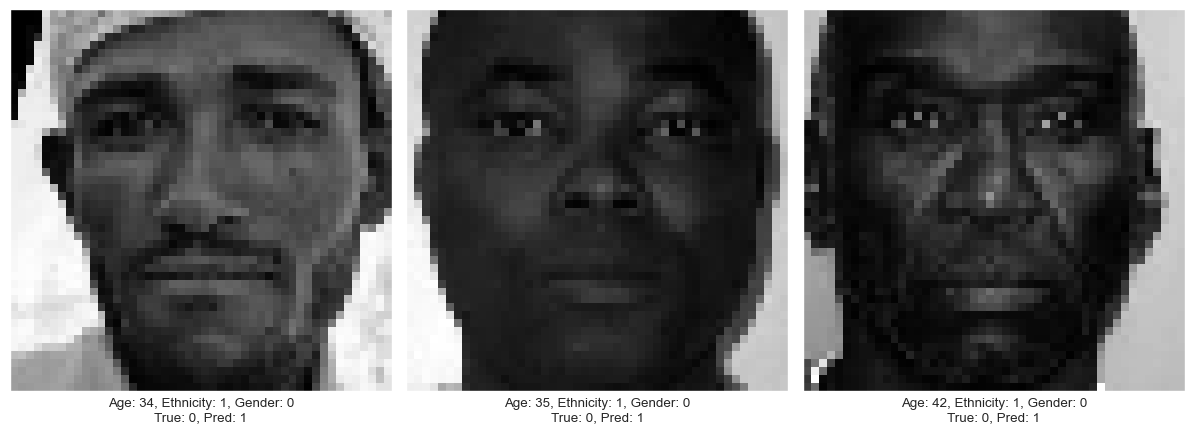

In [ ]:
# Example usage:
# Assuming you have all the necessary data and model loaded
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#filter_by = {'age': 25, 'ethnicity': 1, 'gender': 0} # Example filter
filter_by = {'ethnicity': 1, 'gender': 0} # Example filter
display_misclassified_images_by_labels(val_loader, model, device, age_gender_data, val_indices, filter_by)


In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)



age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 154 (9.60%)
  10-14: Total = 589, Misclassified = 58 (9.85%)
  100-104: Total = 14, Misclassified = 3 (21.43%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 1 (16.67%)
  115-119: Total = 7, Misclassified = 4 (57.14%)
  15-19: Total = 942, Misclassified = 119 (12.63%)
  20-24: Total = 2310, Misclassified = 261 (11.30%)
  25-29: Total = 1634, Misclassified = 178 (10.89%)

age - Misclassification distribution:
  0-4: Misclassified = 154 (19.79%) of Total Misclassified = 778
  10-14: Misclassified = 58 (7.46%) of Total Misclassified = 778
  100-104: Misclassified = 3 (0.39%) of Total Misclassified = 778
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 778
  110-114: Misclassified = 1 (0.13%) of Total Misclassified = 778
  115-119: Misclassified = 4 (0.51%) of Total Misclassified = 778
  15-19: Misclassified = 119 (15.30%) of Total Misclassified = 778
  20-24: Misclassif

# 11. We create a new version of the RESNET Architecture with attention and other improvements

def accumulate_batch_stats(batch):
    # Convert batch to float, and reshape to 2D [batch_size*height*width, channels]
    reshaped_batch = batch.float().reshape(-1, batch.shape[-3])
    # Calculate mean and std here
    mean = reshaped_batch.mean(0)
    std = reshaped_batch.std(0)
    return mean, std

means = []
stds = []
for images, _ in DataLoader(train_dataset, batch_size=32, shuffle=False):
    mean, std = accumulate_batch_stats(images)
    means.append(mean)
    stds.append(std)

# Calculate the overall mean and std
overall_mean = torch.stack(means).mean(0)
overall_std = torch.stack(stds).mean(0)

print(f"Mean: {overall_mean}")
print(f"Std: {overall_std}")


def update_stats(mean, std, batch):
    batch_mean = torch.mean(batch, dim=[0, 2, 3])
    batch_std = torch.std(batch, dim=[0, 2, 3])
    updated_mean = (mean * len(means) + batch_mean) / (len(means) + 1)
    updated_std = (std * len(stds) + batch_std) / (len(stds) + 1)
    return updated_mean, updated_std

running_mean = torch.zeros(1)  # Assuming grayscale, adjust for RGB by using torch.zeros(3)
running_std = torch.zeros(1)

for images, _ in DataLoader(train_dataset, batch_size=32, shuffle=False):
    images_mean, images_std = update_stats(running_mean, running_std, images)
    running_mean = images_mean
    running_std = images_std

print(f"Running Mean: {running_mean}")
print(f"Running Std: {running_std}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Define the basic block of ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Squeeze-and-Excitation block
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            # This adds a convolutional layer to the shortcut path to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # Apply SE block
        out += self.shortcut(x)  # Element-wise addition
        out = F.relu(out)
        return out

# Define a simple ResNet model for FashionMNIST
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer before the blocks
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Layers of blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classifier
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Number of blocks in each layer
num_blocks = [2, 2, 2, 2]

# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = ResNet(BasicBlock, num_blocks).to(device)
print(model3)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, k

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR

# Start timer
start_time = time.time()

# Define your model (assuming `MyModel` is a class defining your CNN)
model3 = ResNet(BasicBlock, num_blocks).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters())
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Assuming device is defined as follows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

num_epochs = 15  # Or whatever number of epochs you've set

for epoch in range(num_epochs):
    model3.train()  # Set the model to training mode
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the device
        
        # Forward pass
        outputs = model3(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)  # Multiply by batch size
        
        # Calculate predictions for F1-Score
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()  # Update the learning rate
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1_score = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for label imbalance
    
    print(f'{Back.RED}Epoch:{Back.RESET} {Back.BLUE}{epoch+1}/{num_epochs}{Back.RESET}, '
          f'{Back.RED}Loss:{Back.RESET} {Back.BLUE}{epoch_loss:.4f}{Back.RESET}, '
          f'{Back.RED}Accuracy:{Back.RESET} {Back.BLUE}{epoch_accuracy*100:.2f}%{Back.RESET}, '
          f'{Back.RED}F1-Score:{Back.RESET} {Back.BLUE}{epoch_f1_score:.4f}{Back.RESET}')

# End timer
end_time = time.time()

Training on device: cuda
Epoch: 1/15, Loss: 0.4453, Accuracy: 79.06%, F1-Score: 0.7906
Epoch: 2/15, Loss: 0.3155, Accuracy: 86.03%, F1-Score: 0.8603
Epoch: 3/15, Loss: 0.2648, Accuracy: 88.63%, F1-Score: 0.8863
Epoch: 4/15, Loss: 0.2355, Accuracy: 90.04%, F1-Score: 0.9005
Epoch: 5/15, Loss: 0.2024, Accuracy: 91.47%, F1-Score: 0.9147
Epoch: 6/15, Loss: 0.1842, Accuracy: 92.29%, F1-Score: 0.9229
Epoch: 7/15, Loss: 0.1552, Accuracy: 93.80%, F1-Score: 0.9380
Epoch: 8/15, Loss: 0.1327, Accuracy: 94.47%, F1-Score: 0.9447
Epoch: 9/15, Loss: 0.1071, Accuracy: 95.81%, F1-Score: 0.9581
Epoch: 10/15, Loss: 0.0901, Accuracy: 96.50%, F1-Score: 0.9650
Epoch: 11/15, Loss: 0.0724, Accuracy: 97.28%, F1-Score: 0.9728
Epoch: 12/15, Loss: 0.0636, Accuracy: 97.65%, F1-Score: 0.9765
Epoch: 13/15, Loss: 0.0464, Accuracy: 98.29%, F1-Score: 0.9829
Epoch: 14/15, Loss: 0.0440, Accuracy: 98.46%, F1-Score: 0.9846
Epoch: 15/15, Loss: 0.0370, Accuracy: 98.70%, F1-Score: 0.9870


In [ ]:
# Calculate and print the duration
duration = end_time - start_time
print(f'{Back.RED}Training completed in (seconds):{Back.RESET}',
    f"\n{Back.BLUE}{duration:.3f}{Back.RESET}")

Training completed in (seconds): 
310.803


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch

# Assuming model2 is your defined ResNet model and val_loader is your validation dataset loader
# Ensure the model is in evaluation mode
model3.eval()

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

# Initialize lists to monitor test results and wrong predictions
y_pred = []
y_true = []
wrong_images = []
wrong_labels = []
correct_labels = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model3(images)

        # Get prediction from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Append batch prediction results
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

        # Identify and store wrong predictions
        mismatches = predicted  != labels
        if any(mismatches):
            wrong_images.append(images[mismatches].cpu())
            wrong_labels.append(predicted[mismatches].cpu().numpy())
            correct_labels.append(labels[mismatches].cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'{Back.RED}Accuracy:{Back.RESET}',
    f"\n{Back.BLUE}{accuracy:.4f}{Back.RESET}")
print(f'{Back.RED}Precision:{Back.RESET}',
    f"\n{Back.BLUE}{precision:.4f}{Back.RESET}")
print(f'{Back.RED}Recall:{Back.RESET}',
    f"\n{Back.BLUE}{recall:.4f}{Back.RESET}")
print(f'{Back.RED}F1 Score:{Back.RESET}',
    f"\n{Back.BLUE}{f1:.4f}{Back.RESET}")
print(f'{Back.RED}Confusion Matrix:{Back.RESET}',
    f"\n{Back.BLUE}{conf_matrix}{Back.RESET}")

Accuracy: 
0.8915
Precision: 
0.8911
Recall: 
0.8912
F1 Score: 
0.8912
Confusion Matrix: 
[[3353  388]
 [ 384 2987]]


In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 164 (10.22%)
  10-14: Total = 589, Misclassified = 67 (11.38%)
  100-104: Total = 14, Misclassified = 2 (14.29%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 1 (16.67%)
  115-119: Total = 7, Misclassified = 2 (28.57%)
  15-19: Total = 942, Misclassified = 104 (11.04%)
  20-24: Total = 2310, Misclassified = 247 (10.69%)
  25-29: Total = 1634, Misclassified = 185 (11.32%)

age - Misclassification distribution:
  0-4: Misclassified = 164 (21.24%) of Total Misclassified = 772
  10-14: Misclassified = 67 (8.68%) of Total Misclassified = 772
  100-104: Misclassified = 2 (0.26%) of Total Misclassified = 772
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 772
  110-114: Misclassified = 1 (0.13%) of Total Misclassified = 772
  115-119: Misclassified = 2 (0.26%) of Total Misclassified = 772
  15-19: Misclassified = 104 (13.47%) of Total Misclassified = 772
  20-24: Misclass